<a href="https://colab.research.google.com/github/hargurjeet/MachineLearning/blob/master/Used_Car_Quality_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Car Quality Detection by XBboost and Random Forests**

Machine learning is the science of getting computers to act without being explicitly programmed. In the past decade, machine learning has given us self-driving cars, practical speech recognition, effective web search, and a vastly improved understanding of the human genome. Machine learning is so pervasive today that you probably use it dozens of times a day without knowing it. In this notebook I implement two of the most known machine learning algorthim to predict the quality of a car.

# **Table Of Contents**<a name="top"></a>


---



---


  1. [About the Dataset](#1)
  2. [Loading the dataset Preprocessing](#2)
  3. [Expainatory Data Analysis](#3)
  4. [Feature Engineering](#4)
  5. [Data Cleaning and Pipelines Implementation](#5)
  6. [Implemneting Random Forest](#6)
  7. [Hyperparameter Tuning - Random Forest](#7)
  8. [Implemneting XBboost Forest](#8)
  9. [Hyperparameter Tuning - XBboost](#9)
  10. [Sample Prediction and saving the model](#10)
  11. [Summary](#11)
  12. [Future Work](#12)
  13. [References](#13)

# 1: AboutDataset <a name="1"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

One of the biggest challenges of an auto dealership purchasing a used car at an auto auction is the risk of that the vehicle might have serious issues that prevent it from being sold to customers. The auto community calls these unfortunate purchases "kicks".

Kicked cars often result when there are tampered odometers, mechanical issues the dealer is not able to address, issues with getting the vehicle title from the seller, or some other unforeseen problem. Kick cars can be very costly to dealers after transportation cost, throw-away repair work, and market losses in reselling the vehicle.

Modelers who can figure out which cars have a higher risk of being kick can provide real value to dealerships trying to provide the best inventory selection possible to their customers.

The challenge of this competition is to predict if the car purchased at the Auction is a Kick (bad buy).

- The challenge of this competition is to predict if the car purchased at the Auction is a good / bad buy.
- All the variables in the data set are defined in the file Carvana_Data_Dictionary.txt 
- The data contains missing values 
- The dependent variable (IsBadBuy) is binary (C2)
- There are 32 Independent variables (C3-C34)
- The data set is split to 60% training and 40% testing.

# 2: Loading and Preprocessing Dataset<a name="2"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

Downloading all the required python packages to get started, also imported all the required libraries

In [1]:
!pip install numpy pandas matplotlib seaborn --quiet
!pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

     |████████████████████████████████| 68 kB 3.4 MB/s 
     |████████████████████████████████| 166.7 MB 7.8 kB/s 
     |████████████████████████████████| 2.0 MB 37.3 MB/s 
     |████████████████████████████████| 22.3 MB 100.4 MB/s 


In [2]:
#importing dataset
import os
import opendatasets as od
import pandas as pd
import numpy as np

#Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

#For Missing Value and Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import time

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

To download the dataset from Kaggle, I use the library **od**.

To connect to kaggle enter user Kaggle username name and API key. 

Please read though this article to understand the process of getting your API key from kaggle.

https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/

In [3]:
od.download('https://www.kaggle.com/c/DontGetKicked/data?select=test.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hargurjeet
Your Kaggle Key: ··········


100%|██████████| 10.2M/10.2M [00:00<00:00, 62.5MB/s]


Extracting archive ./DontGetKicked/DontGetKicked.zip to ./DontGetKicked


Below are the list of files downloaded. You can access all the downloaded filename using os.listdir(<'downloaded folder name'>)

In [4]:
os.listdir('DontGetKicked')

['training.csv',
 'test.csv',
 'example_entry.csv',
 'test.zip',
 'Carvana_Data_Dictionary.txt',
 'training.zip']

I use pandas to read the train and test data sets. Here I access few records of training dataset

In [5]:
train=pd.read_csv('/content/DontGetKicked/training.csv') 
test= pd.read_csv('/content/DontGetKicked/test.csv')
train.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1.0,Alloy,89046,OTHER ASIAN,MEDIUM,OTHER,8155.0,9829.0,11636.0,13600.0,7451.0,8552.0,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1.0,Alloy,93593,AMERICAN,LARGE TRUCK,CHRYSLER,6854.0,8383.0,10897.0,12572.0,7456.0,9222.0,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2.0,Covers,73807,AMERICAN,MEDIUM,CHRYSLER,3202.0,4760.0,6943.0,8457.0,4035.0,5557.0,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,1.0,Alloy,65617,AMERICAN,COMPACT,CHRYSLER,1893.0,2675.0,4658.0,5690.0,1844.0,2646.0,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,2.0,Covers,69367,AMERICAN,COMPACT,FORD,3913.0,5054.0,7723.0,8707.0,3247.0,4384.0,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


# 3: Expainatory Data Analysis <a name="3"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

## 3.1: Understanding the manufacture year of the vechicles

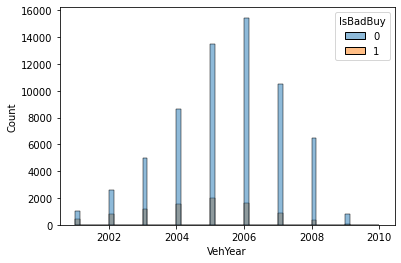

In [6]:
sns.histplot(data=train, x="VehYear", hue='IsBadBuy');

It is evident that although the max vechicles are with manufacturing of 2005 and 2006, the percentage of vechicle turn out to be kicks are less as compared to the manufacturing year 2001 and 2002 where this rate seems to be close to 50%.

Vechile from the later year of 2008 and 2009 seems to have minimum no of vechicle that turn out bad.

## 3.2 Checking if the autction has any influence or vechile being bad.

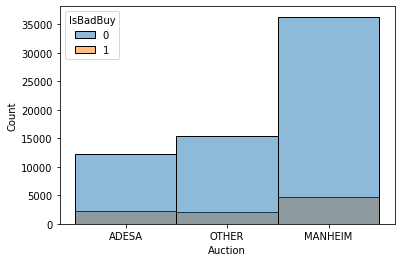

In [7]:
sns.histplot(data=train, x="Auction", hue='IsBadBuy');

It is observed at MANHEIM auction most of the car sold have the turned out good.

## 3.3 Understanding the Manufactures

In [8]:
train.Make.value_counts().head(10)

CHEVROLET    17248
DODGE        12912
FORD         11305
CHRYSLER      8844
PONTIAC       4258
KIA           2484
SATURN        2163
NISSAN        2085
HYUNDAI       1811
JEEP          1644
Name: Make, dtype: int64

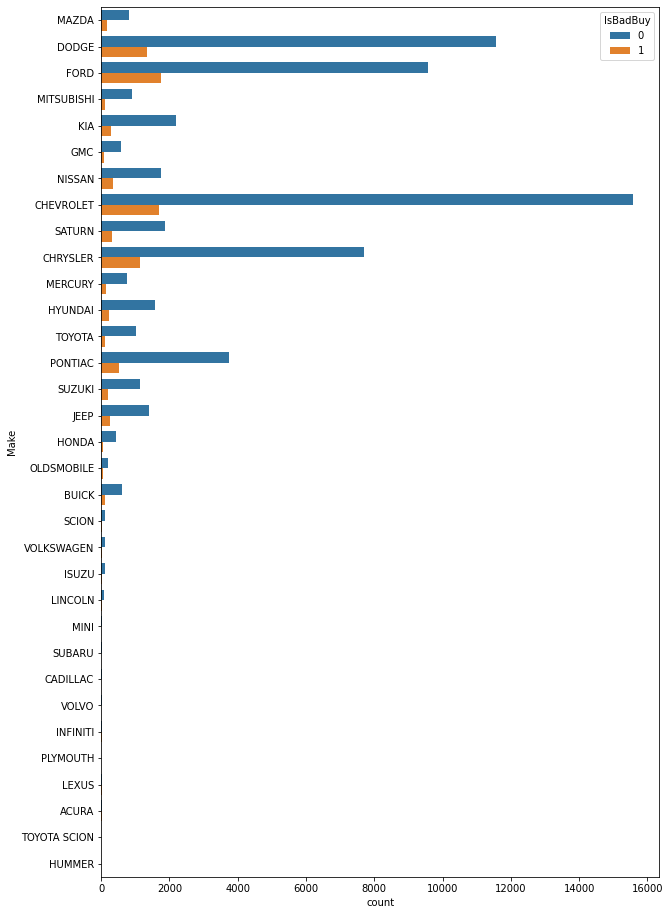

In [9]:
fig, ax = plt.subplots(figsize=(10,16))
sns.countplot(y="Make", data=train, hue='IsBadBuy')
plt.show()

Cars from mnaufacutres DODGE and FORD seems to have maximum no of kicked cars

## 3.4 Impact of color of car being kicked or not

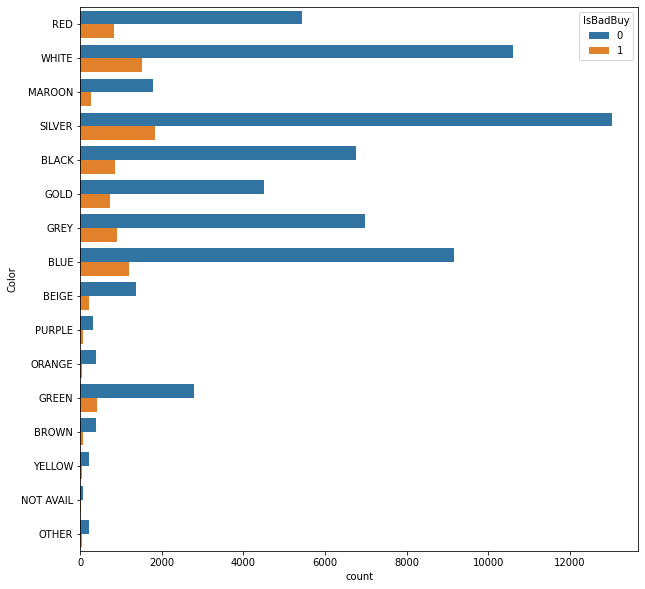

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(y="Color", data=train, hue='IsBadBuy')
plt.show()

There is a high probablity of repainting of kicked cars. High no of kicked cars are painted in White, Sliver, Blue

## 3.5 Impact of transmission type on kicked cars

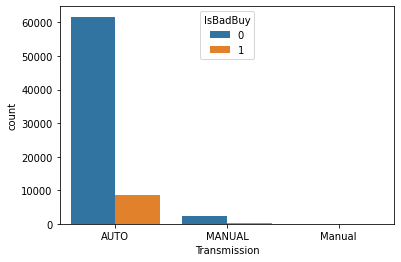

In [11]:
sns.countplot(x="Transmission", data=train, hue='IsBadBuy');

Couple of observations here

- Most of the car have AUTO transmission and kicked cars out of these are about  16%.

- Data quality issue, For some cars transmission type is recorded as 'Manual' instead of 'MANUAL'

# 4: Feature Engineering <a name="4"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              72983 non-null  int64  
 1   IsBadBuy                           72983 non-null  int64  
 2   PurchDate                          72983 non-null  object 
 3   Auction                            72983 non-null  object 
 4   VehYear                            72983 non-null  int64  
 5   VehicleAge                         72983 non-null  int64  
 6   Make                               72983 non-null  object 
 7   Model                              72983 non-null  object 
 8   Trim                               70623 non-null  object 
 9   SubModel                           72975 non-null  object 
 10  Color                              72975 non-null  object 
 11  Transmission                       72974 non-null  obj

Before performing the feature engineering, let us first check the data quality and identify null values.

In [13]:
print(train.isnull().sum())

RefId                                    0
IsBadBuy                                 0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  2360
SubModel                                 8
Color                                    8
Transmission                             9
WheelTypeID                           3169
WheelType                             3174
VehOdo                                   0
Nationality                              5
Size                                     5
TopThreeAmericanName                     5
MMRAcquisitionAuctionAveragePrice       18
MMRAcquisitionAuctionCleanPrice         18
MMRAcquisitionRetailAveragePrice        18
MMRAcquisitonRetailCleanPrice           18
MMRCurrentAuctionAveragePrice          315
MMRCurrentA

In [14]:
print(test.isnull().sum())

RefId                                    0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  1550
SubModel                                 5
Color                                    4
Transmission                             3
WheelTypeID                           2188
WheelType                             2188
VehOdo                                   0
Nationality                              7
Size                                     7
TopThreeAmericanName                     7
MMRAcquisitionAuctionAveragePrice       10
MMRAcquisitionAuctionCleanPrice         10
MMRAcquisitionRetailAveragePrice        10
MMRAcquisitonRetailCleanPrice           10
MMRCurrentAuctionAveragePrice          143
MMRCurrentAuctionCleanPrice            143
MMRCurrentR

**Checking Duplicates**

In [15]:
train[train.duplicated()]

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost


In [16]:
test[test.duplicated()]

,RefId,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost


As we see above, many column contains null values. It is important for us to understand the relevant columns that would help model to better generalize.
Hence following columns seems not relevant that are requied to be passed to the model
- PurchDate (Date might not be relevant by Year would be)
- WheelTypeID
- Model
- Trim 
- SubModel
- Make
- VNZIP1
- VNST
- Color

Here I create few addtional column using the existing column to drive some addtional features from the datasets.

The additional features help the model in better training, aslo ensuring the model to be more generalized.

In [17]:
def split_date(df):
  df['PurchDate'] = pd.to_datetime(df['PurchDate'])
  df['Year'] = df.PurchDate.dt.year

In [18]:
def MeanOnFeatures(df):
  df['mean_MMRCurrentAuctionAveragePrice_Make']=train.groupby(['Make'])['MMRCurrentAuctionAveragePrice'].transform('mean')
  df['mean_MMRCurrentAuctionAveragePrice_Model']=train.groupby(['Model'])['MMRCurrentAuctionAveragePrice'].transform('mean')
  df['mean_MMRCurrentAuctionAveragePrice_Trim']=train.groupby(['Trim'])['MMRCurrentAuctionAveragePrice'].transform('mean')
  df['mean_MMRCurrentAuctionAveragePrice_SubModel']=train.groupby(['SubModel'])['MMRCurrentAuctionAveragePrice'].transform('mean')
  df['mean_MMRCurrentAuctionAveragePrice_Color']=train.groupby(['Color'])['MMRCurrentAuctionAveragePrice'].transform('mean')
  df['mean_MMRCurrentAuctionAveragePrice_Transmission']=train.groupby(['Transmission'])['MMRCurrentAuctionAveragePrice'].transform('mean')

In [19]:
print(train.shape, test.shape)

(72983, 34) (48707, 33)


In [20]:
split_date(train)
split_date(test)

print(train.shape, test.shape)

MeanOnFeatures(train)
MeanOnFeatures(test)

(72983, 35) (48707, 34)


In [21]:
print(train.shape, test.shape)

(72983, 41) (48707, 40)


In [22]:
not_relevant_coulmns = ["PurchDate", "WheelTypeID", "Model", "Trim", "SubModel", "VNZIP1", "VNST", "Make", "Color"]

def remove_features(df):
  df.drop(not_relevant_coulmns, axis=1, inplace=True)

remove_features(train)
remove_features(test)

In [23]:
print(train.shape, test.shape)

(72983, 32) (48707, 31)


**Handling NaN**

In [24]:
train.isnull().sum()

RefId                                                  0
IsBadBuy                                               0
Auction                                                0
VehYear                                                0
VehicleAge                                             0
Transmission                                           9
WheelType                                           3174
VehOdo                                                 0
Nationality                                            5
Size                                                   5
TopThreeAmericanName                                   5
MMRAcquisitionAuctionAveragePrice                     18
MMRAcquisitionAuctionCleanPrice                       18
MMRAcquisitionRetailAveragePrice                      18
MMRAcquisitonRetailCleanPrice                         18
MMRCurrentAuctionAveragePrice                        315
MMRCurrentAuctionCleanPrice                          315
MMRCurrentRetailAveragePrice   

I observed one particular scenario where the categrical values are varying becuase of the case sensitive issue. 

In [25]:
train.Transmission.value_counts()

AUTO      70398
MANUAL     2575
Manual        1
Name: Transmission, dtype: int64

In [26]:
# This should reslove this difference
train["Transmission"].replace("Manual", "MANUAL", inplace=True)

The target values seems to be highly imbalance. This is not good for our machine learning model

In [27]:
train.IsBadBuy.value_counts()

0    64007
1     8976
Name: IsBadBuy, dtype: int64

1    64007
0    64007
Name: IsBadBuy, dtype: int64


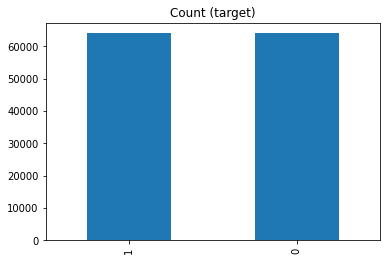

In [28]:
count_class_0, count_class_1 = train.IsBadBuy.value_counts()

df_class_0 = train[train['IsBadBuy'] == 0]
df_class_1 = train[train['IsBadBuy'] == 1]

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print(df_test_over.IsBadBuy.value_counts())

df_test_over.IsBadBuy.value_counts().plot(kind='bar', title='Count (target)');

# 5: Data Cleaning, Spliting and Pipelines Implementation <a name="5"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

We perform the following tasks under this section
- Segregating the features and target.
- Identifying the numberical and categorical columns.
- Spliting the dataset between train and testing. 
- For numberical columns
  - Used KNN Imputer to fill the missing values.
  - MinMaxScaler() to normalize the numberical values.
- For categorical columns
  - Used Simple Imputer to fill up the missing values.
  - OneHotEncoder to all the catogorical columns.
- Finally all the above steps are put inside a **pipelines**

In [29]:
#create X and y datasets for splitting 
X = df_test_over.drop(["RefId",'IsBadBuy'], axis=1)
y = df_test_over['IsBadBuy']

In [30]:
all_features = X.columns
all_features = all_features.tolist()

In [31]:
numerical_features = [c for c, dtype in zip(X.columns, X.dtypes)
                     if dtype.kind in ['i','f']]
categorical_features = [c for c, dtype in zip(X.columns, X.dtypes)
                     if dtype.kind not in ['i','f']]

In [32]:
#import train_test_split library
from sklearn.model_selection import train_test_split

# create train test split
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42) 

In [33]:
preprocessor = make_column_transformer(
    
    (make_pipeline(
    SimpleImputer(strategy = 'median'),
    # KNNImputer(n_neighbors=2, weights="uniform"),
    MinMaxScaler()), numerical_features),
    
    (make_pipeline(
    SimpleImputer(strategy = 'constant', fill_value = 'missing'),
    OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features),
    
)

In [34]:
preprocessor_best = make_pipeline(preprocessor, 
                                  VarianceThreshold(), 
                                  SelectKBest(f_classif, k = 50)
                                 )

# 6: Implemneting Random Forest <a name="6"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

In [ ]:
RF_Model = make_pipeline(preprocessor_best, RandomForestClassifier(n_estimators = 100))

In [ ]:
RF_Model.fit(X_train, y_train)
RF_Model.score(X_train, y_train)

1.0

The training set accuracy is close to 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation/test set too.

We can make predictions and compute accuracy in one step using model.score

In [ ]:
RF_Model.score(X_test, y_test)

0.9843770342403333

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. One possible reason might be because we to reslove oversampling we ended up inducing some overlaps between testing and training set hence we are observing a very high accuracy. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.

I can now think of two possible solutions
1. hyperparamterization to over come the overfitting. I will cover this in next section.
2. Instead of spliting the data in train and testing set. Let us train on the entire set in one go this valiation strategy is called as K-fold cross validation. To illustrate this via an example I will implement XGboost an apply cross validation on top on it.

# 7: Hyperparamter Tuning  - Random Forest <a name="7"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

As we saw in the previous section, our random tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was only marginally better than a dumb baseline model. This phenomenon is called overfitting, and in this section, we'll look at some strategies for reducing overfitting. The process of reducing overfitting is known as regularlization.


By varying the following fields, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 19)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
#Maximum number of levels in tree
max_depth = [2,4,6,8]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [ ]:
# Create the param grid
param_grid = {'randomforestclassifier__n_estimators': n_estimators,
               'randomforestclassifier__max_features': max_features,
               'randomforestclassifier__max_depth': max_depth,
               'randomforestclassifier__min_samples_split': min_samples_split,
               'randomforestclassifier__min_samples_leaf': min_samples_leaf,
               'randomforestclassifier__bootstrap': bootstrap
             }
print(param_grid)

{'randomforestclassifier__n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000], 'randomforestclassifier__max_features': ['auto', 'sqrt'], 'randomforestclassifier__max_depth': [2, 4, 6, 8], 'randomforestclassifier__min_samples_split': [2, 5], 'randomforestclassifier__min_samples_leaf': [1, 2], 'randomforestclassifier__bootstrap': [True, False]}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf_RandomGrid = RandomizedSearchCV(estimator = RF_Model, param_distributions = param_grid, cv = 3, verbose=1, n_jobs = -1, n_iter = 5, scoring = 'f1')

In [ ]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 2min 11s, sys: 1.26 s, total: 2min 13s
Wall time: 10min 34s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('minmaxscaler',
                                                                                                                 MinMaxScaler())]),
                                                                                                ['VehYear',
                                                                            

In [ ]:
rf_RandomGrid.score(X_train, y_train)

0.7066352149847023

In [ ]:
rf_RandomGrid.score(X_test, y_test)

0.6951602765556254

Although the accuracy of overall model is reduced, We have significantly reduced overfitting as we see the co relation between the training and testing results. I now pick the best parameters which would help to me to achive better accuray from the avalaible list of parameters. 

Sklearn provides us the library **gridsearch CV** to help us running all the model over the list of parameter instead we doing it manually and **best_estimator** helps us in selecting the best parameter on which the model would befrom best

In [ ]:
rf_RandomGrid.best_estimator_

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['VehYear',
                                                                    'VehicleAge',
                                                                    'VehOdo',
                                                                    'MMRAcquisitionAuctionAveragePrice',
                                                                    

Accuracy

In [ ]:
print(f'Train : {rf_RandomGrid.score(X_train, y_train):.3f}')
print(f'Test : {rf_RandomGrid.score(X_test, y_test):.3f}')

Train : 0.707
Test : 0.695


In [ ]:
X_test.head()

,Auction,VehYear,VehicleAge,Transmission,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VehBCost,IsOnlineSale,WarrantyCost,Year,mean_MMRCurrentAuctionAveragePrice_Make,mean_MMRCurrentAuctionAveragePrice_Model,mean_MMRCurrentAuctionAveragePrice_Trim,mean_MMRCurrentAuctionAveragePrice_SubModel,mean_MMRCurrentAuctionAveragePrice_Color,mean_MMRCurrentAuctionAveragePrice_Transmission
66800,ADESA,2006,4,AUTO,Alloy,79425,TOP LINE ASIAN,MEDIUM,OTHER,7217.0,8690.0,10887.0,12125.0,7813.0,9250.0,11633.0,13264.0,NaN,NaN,17675,7560.0,0,686,2010,7021.627649,7091.027900,6171.007828,5577.972891,6794.120395,6180.060667
50447,MANHEIM,2002,7,AUTO,Covers,56309,AMERICAN,VAN,GM,2028.0,3561.0,2690.0,4346.0,2634.0,4110.0,3345.0,4939.0,NaN,NaN,99750,3800.0,0,3676,2009,6232.051888,3142.654545,6466.957348,2244.950000,5691.041273,6180.060667
29350,OTHER,2008,1,AUTO,Covers,51993,AMERICAN,MEDIUM,CHRYSLER,7239.0,7802.0,8318.0,8926.0,7524.0,8277.0,10564.0,11431.0,NaN,NaN,99761,6800.0,0,754,2009,6546.501242,7586.763860,5768.078539,7387.896366,6007.655969,6180.060667
49706,OTHER,2004,5,AUTO,Covers,77084,AMERICAN,MEDIUM,CHRYSLER,3487.0,4488.0,4266.0,5347.0,3487.0,4488.0,4266.0,5347.0,NaN,NaN,835,4670.0,0,1389,2009,6032.147123,5249.025385,6171.007828,5577.972891,6053.234606,6180.060667
56014,OTHER,2005,4,AUTO,Alloy,86397,AMERICAN,CROSSOVER,CHRYSLER,6947.0,8346.0,8003.0,9514.0,6150.0,7713.0,7142.0,8830.0,NaN,NaN,18880,7900.0,0,1503,2009,6032.147123,7732.619808,5831.287933,6996.750000,6178.132744,6180.060667


In [ ]:
X_test.iloc[1:2, :]

,Auction,VehYear,VehicleAge,Transmission,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VehBCost,IsOnlineSale,WarrantyCost,Year,mean_MMRCurrentAuctionAveragePrice_Make,mean_MMRCurrentAuctionAveragePrice_Model,mean_MMRCurrentAuctionAveragePrice_Trim,mean_MMRCurrentAuctionAveragePrice_SubModel,mean_MMRCurrentAuctionAveragePrice_Color,mean_MMRCurrentAuctionAveragePrice_Transmission
50447,MANHEIM,2002,7,AUTO,Covers,56309,AMERICAN,VAN,GM,2028.0,3561.0,2690.0,4346.0,2634.0,4110.0,3345.0,4939.0,NaN,NaN,99750,3800.0,0,3676,2009,6232.051888,3142.654545,6466.957348,2244.95,5691.041273,6180.060667


In [ ]:
array = rf_RandomGrid.predict_proba(X_test.iloc[1:2, :])[0]
array[0]

0.3253215736455985

It is observed that although the accuray has dropped significantly but the deviation between the training and test sets is minimal. Hence our model is fairly generalized.

Results captured can now be submitted to kaggle. In the following block we create the output file and the same can be uploaded to kaggle

In [ ]:
preds = rf_RandomGrid.predict(test.iloc[:, 1:31])
output = pd.DataFrame({'Refid': test.RefId, 'IsBadBuy': preds})
output.to_csv('my_submission_rf_model_hyperparameterized.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


# <font color="white" size=+2.0><b>8: Implementing XBboost Forest</b></font> <a name="8"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

First we will setup our pipelines as usual

In [35]:
preprocessor = make_column_transformer(
    
    (make_pipeline(
    #SimpleImputer(strategy = 'median'),
    KNNImputer(n_neighbors=2, weights="uniform"),
    MinMaxScaler()), numerical_features),
    
    (make_pipeline(
    SimpleImputer(strategy = 'constant', fill_value = 'missing'),
    OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features),

)

preprocessor_best = make_pipeline(preprocessor,
                                  VarianceThreshold(), 
                                  SelectKBest(f_classif, k = 50)
                                 )


Here we call the xgboost classifier

In [36]:
from xgboost import XGBClassifier
import xgboost as xgb
# model = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4, use_label_encoder=False)

XG_model = make_pipeline(preprocessor_best, XGBClassifier(n_estimators = 100))

Now we fit the model to the entire dataset. Remember we wont be performing train test split instead we will use K fold cross validation to evaluta our model.

In [37]:
%%time

# XG_model.fit(X_train, y_train)
XG_model.fit(X, y)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:10:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 2min 4s, sys: 3.44 s, total: 2min 8s
Wall time: 1min 31s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('knnimputer',
                                                                                    KNNImputer(n_neighbors=2)),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['VehYear',
                                                                    'VehicleAge',
                                                                    'VehOdo',
                                                                    'MMRAcquisitionAuctionAveragePrice',
                                                                    'MMRAcquis

In [ ]:
# XG_model.score(X_train, y_train)
XG_model.score(X, y)

0.8379317887106098

Our model has shown the accuracy of about 83% when tested on train set. Let us now implement the k fold cross validation

**K Fold Cross Validation**

In [38]:
from sklearn.model_selection import KFold

In [39]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = make_pipeline(preprocessor_best, XGBClassifier(random_state=42, n_jobs=-1, **params))
    model.fit(X_train, train_targets)
    train_accuracy = model.score(X_train, train_targets)
    val_accuracy = model.score(X_val, val_targets)
    return model, train_accuracy, val_accuracy

In [40]:
kfold = KFold(n_splits=5)

In [ ]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], y.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], y.iloc[val_idxs]
    model, train_accuracy, val_accuracy = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train Accuracy: {}, Validation Accuracy: {}'.format(train_accuracy, val_accuracy))

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:00:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 0.7309664000937399, Validation Accuracy: 0.38831386946842167


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:02:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 0.7203230121764264, Validation Accuracy: 0.3498418154122564


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:03:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 0.7176377537569206, Validation Accuracy: 0.47713158614224893


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:05:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 0.7412973215767837, Validation Accuracy: 0.4256923016833965


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:06:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Accuracy: 0.7384779127446003, Validation Accuracy: 0.42785719865635496


Train Accuracy: 0.7321576783743934, Validation Accuracy: 0.3810881537319845

Train Accuracy: 0.7148939078809894, Validation Accuracy: 0.39284458852478227

Train Accuracy: 0.7126871136889592, Validation Accuracy: 0.48498222864508067

Train Accuracy: 0.7391100565368954, Validation Accuracy: 0.43030113658555635

Train Accuracy: 0.7381556848806781, Validation Accuracy: 0.4356690883524725


As observed here although the accuracy of training set is high but validation set seems to exbhit very low accuracy. So none of these model is good enough but we can take avaerage of these model so that the errors are reduced. Let's also define a function to average predictions from the 5 different models.

In [ ]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

Now we predict the test outcome based on the average learning of all above 5 models

In [ ]:
preds = predict_avg(models, test.iloc[:, 1:31])

# 9: Hyperparameter tuning - XGboost <a name="9"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

We write a helper function to perfrom hyperparameter tuning along with k folds

In [41]:
def test_params_kfold(n_splits, **params):
    train_accuracys, val_accuracys, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], y.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], y.iloc[val_idxs]
        model, train_accuracy, val_accuracy = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_accuracys.append(train_accuracy)
        val_accuracys.append(val_accuracy)
    print('Train accuracy: {}, Validation accuracy: {}'.format(np.mean(train_accuracys), np.mean(val_accuracys)))
    return models

Now, I start expertimenting with parameter. There is no hard and fast rules on picking the parameter to start with. I usaually prefer the way they appear in the order as per the sklearn library. The values to pass on these parameter comes with experience but a thumb rule can be to always start with smaller values.

In [ ]:
%%time
test_params_kfold(5, n_estimators=10)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:24:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:26:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:27:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:29:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy: 0.7354371236618664, Validation accuracy: 0.4152749196146237
CPU times: user 8min 8s, sys: 16.5 s, total: 8min 24s
Wall time: 7min 20s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['VehYear',
                                                                     'VehicleAge',
                                                                     'VehOdo',
                                                                     'MMRAcquisitionAuctionAveragePrice',
                                                                   

In [ ]:
test_params_kfold(5, n_estimators=100)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:50:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy: 0.8558439086394287, Validation accuracy: 0.5863503055462468


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['VehYear',
                                                                     'VehicleAge',
                                                                     'VehOdo',
                                                                     'MMRAcquisitionAuctionAveragePrice',
                                                                   

In [ ]:
test_params_kfold(5, n_estimators=240)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:02:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:04:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:06:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy: 0.9337982657111384, Validation accuracy: 0.7109775997945567


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['VehYear',
                                                                     'VehicleAge',
                                                                     'VehOdo',
                                                                     'MMRAcquisitionAuctionAveragePrice',
                                                                   

In [ ]:
%%time
test_params_kfold(5, n_estimators=500)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:23:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:26:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:29:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:33:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:37:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy: 0.9842146210106149, Validation accuracy: 0.8177317151398802
CPU times: user 28min 4s, sys: 18 s, total: 28min 22s
Wall time: 17min 36s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['VehYear',
                                                                     'VehicleAge',
                                                                     'VehOdo',
                                                                     'MMRAcquisitionAuctionAveragePrice',
                                                                   

After evaluating all the n_estimators it is observed the model perfrom best when n_estimators=500

In [ ]:
%%time
test_params_kfold(5, n_estimators=500, max_depth=2)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:01:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:03:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:05:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:07:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:10:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy: 0.7655920422519624, Validation accuracy: 0.48263483588439604
CPU times: user 15min 4s, sys: 17.5 s, total: 15min 22s
Wall time: 11min


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['VehYear',
                                                                     'VehicleAge',
                                                                     'VehOdo',
                                                                     'MMRAcquisitionAuctionAveragePrice',
                                                                   

In [ ]:
%%time
test_params_kfold(5, n_estimators=500, max_depth=4)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:12:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:15:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:18:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:20:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:23:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy: 0.8922246991362508, Validation accuracy: 0.6454220851143995
CPU times: user 21min 25s, sys: 18.2 s, total: 21min 43s
Wall time: 14min 22s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['VehYear',
                                                                     'VehicleAge',
                                                                     'VehOdo',
                                                                     'MMRAcquisitionAuctionAveragePrice',
                                                                   

In [ ]:
%%time
test_params_kfold(5, n_estimators=500, max_depth=6)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:26:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:30:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:33:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:37:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:40:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy: 0.9842146210106149, Validation accuracy: 0.8177317151398802
CPU times: user 27min 59s, sys: 18.7 s, total: 28min 18s
Wall time: 17min 39s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['VehYear',
                                                                     'VehicleAge',
                                                                     'VehOdo',
                                                                     'MMRAcquisitionAuctionAveragePrice',
                                                                   

After evaluating all the n_estimators, max_depth it is observed the model perfrom best when n_estimators=500 and max_depth=6

In [ ]:
%%time
test_params_kfold(5, n_estimators=500, max_depth=6, learning_rate=0.01)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:49:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:52:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:56:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:00:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:03:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy: 0.7457582687268641, Validation accuracy: 0.4215711794427556
CPU times: user 29min 26s, sys: 18.5 s, total: 29min 44s
Wall time: 18min 25s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['VehYear',
                                                                     'VehicleAge',
                                                                     'VehOdo',
                                                                     'MMRAcquisitionAuctionAveragePrice',
                                                                   

In [ ]:
%%time
test_params_kfold(5, n_estimators=500, max_depth=6, learning_rate=0.1)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:07:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:11:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:14:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:18:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:22:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy: 0.9034226911569588, Validation accuracy: 0.6484452086221697
CPU times: user 28min 22s, sys: 18.7 s, total: 28min 41s
Wall time: 17min 59s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['VehYear',
                                                                     'VehicleAge',
                                                                     'VehOdo',
                                                                     'MMRAcquisitionAuctionAveragePrice',
                                                                   

In [ ]:
%%time
test_params_kfold(5, n_estimators=500, max_depth=6, learning_rate=0.3)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:25:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:29:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:32:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:36:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:39:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy: 0.9842146210106149, Validation accuracy: 0.8177317151398802
CPU times: user 28min 9s, sys: 18.5 s, total: 28min 27s
Wall time: 17min 47s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['VehYear',
                                                                     'VehicleAge',
                                                                     'VehOdo',
                                                                     'MMRAcquisitionAuctionAveragePrice',
                                                                   

In [42]:
%%time
test_params_kfold(5, n_estimators=500, max_depth=6, learning_rate=0.9)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:12:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:15:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:19:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:23:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy: 0.9999648476786982, Validation accuracy: 0.8821465398407305
CPU times: user 29min 24s, sys: 26.5 s, total: 29min 51s
Wall time: 19min 3s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['VehYear',
                                                                     'VehicleAge',
                                                                     'VehOdo',
                                                                     'MMRAcquisitionAuctionAveragePrice',
                                                                   

In [43]:
%%time
test_params_kfold(5, n_estimators=500, max_depth=6, learning_rate=0.99)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:35:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:39:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:43:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy: 0.9999902354620674, Validation accuracy: 0.8798265025767688
CPU times: user 31min 32s, sys: 29.9 s, total: 32min 2s
Wall time: 21min 2s


[Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('columntransformer',
                                   ColumnTransformer(transformers=[('pipeline-1',
                                                                    Pipeline(steps=[('knnimputer',
                                                                                     KNNImputer(n_neighbors=2)),
                                                                                    ('minmaxscaler',
                                                                                     MinMaxScaler())]),
                                                                    ['VehYear',
                                                                     'VehicleAge',
                                                                     'VehOdo',
                                                                     'MMRAcquisitionAuctionAveragePrice',
                                                                   

After evaluating all the n_estimators, max_depth and learning rate it is observed the model perfrom best when n_estimators=500 , max_depth=6 and learning rate=0.9

**Summary**

We have trained the XGBoost on the following parameters and achieved the respective training and val accuracies.
- n_estimatore
  - n_estimatore=10
  - n_estimatore=100
  - n_estimatore=240
  - n_estimatore=500
- max_depth
  - max_depth=2
  - max_depth=4
  - max_depth=6
- learning_rate
 - learning_rate=0.01
 - learning_rate=0.1
 - learning_rate=0.3
 - learning_rate=0.9
 - learning_rate=0.99

Based on the results, we conclude the final model parameters as follow

In [44]:
#Putting it all together
XG_model_with_paramter_tuning = make_pipeline(preprocessor_best, XGBClassifier(n_jobs=-1, random_state=42,
                                                                               n_estimators = 500,learning_rate=0.9, 
                                                                               max_depth=6))

XG_model_with_paramter_tuning.fit(X,y)

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:52:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('knnimputer',
                                                                                    KNNImputer(n_neighbors=2)),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['VehYear',
                                                                    'VehicleAge',
                                                                    'VehOdo',
                                                                    'MMRAcquisitionAuctionAveragePrice',
                                                                    'MMRAcquis

In [46]:
test_preds = XG_model_with_paramter_tuning.predict(test.iloc[:,1:31])

In [48]:
output = pd.DataFrame({'Refid': test.RefId, 'IsBadBuy': test_preds})
output.to_csv('my_submission_xgboost_crossvalidation.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


# 10: Sample prediction and saving model weights <a name="10"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

Making Predictions on New Inputs

In [ ]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    pred = rf_RandomGrid.predict(input_df)
    prob = rf_RandomGrid.predict_proba(input_df)[0]
    return pred, prob[0]

In [ ]:
new_input = {'Auction':'ADESA', 
             'VehYear':2004, 
             'VehicleAge':6, 
             'Transmission':'AUTO', 
             'WheelType':'Alloy',
             'VehOdo':33333, 
             'Nationality':'TOP LINE ASIAN', 
             'Size':'MEDIUM',
             'TopThreeAmericanName':'OTHER',
             'MMRAcquisitionAuctionAveragePrice':7777, 
             'MMRAcquisitionAuctionCleanPrice':8888,
             'MMRAcquisitionRetailAveragePrice':10000, 
             'MMRAcquisitonRetailCleanPrice':12000,
             'MMRCurrentAuctionAveragePrice':7777, 
             'MMRCurrentAuctionCleanPrice':9999,
             'MMRCurrentRetailAveragePrice':11111, 
             'MMRCurrentRetailCleanPrice':11111,
             'PRIMEUNIT':'NaN', 
             'AUCGUART':'NaN', 
             'BYRNO':17777, 
             'VehBCost':7777, 
             'IsOnlineSale':0,
             'WarrantyCost':600, 
             'Year':2010, 
             'mean_MMRCurrentAuctionAveragePrice_Make':7021.627649,
             'mean_MMRCurrentAuctionAveragePrice_Model':7091.0279,
             'mean_MMRCurrentAuctionAveragePrice_Trim':6171.007828,
             'mean_MMRCurrentAuctionAveragePrice_SubModel':5577.972891,
             'mean_MMRCurrentAuctionAveragePrice_Color':6794.120395,
             'mean_MMRCurrentAuctionAveragePrice_Transmission':6180.060667}

In [ ]:
predict_input(rf_RandomGrid, new_input)

(array([0]), 0.6322008152105398)

The output of our given sample is 0 and as per our model the probablity of output being zero is 63%

**Saving the model**


We can save the parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. Along with the model, it's also important to save imputers, scalers, encoders and even column names. Anything that will be required while generating predictions using the model should be saved.

We can use the joblib module to save and load Python objects on the disk.

In [ ]:
import joblib

car_quality_check = {
    'model': rf_RandomGrid
}

joblib.dump(car_quality_check, 'car_quality_check.joblib')

['car_quality_check.joblib']

The object can be loaded back using joblib.load

In [ ]:
car_quality_check2 = joblib.load('car_quality_check.joblib')

We can check if the reloaded model is bheaving as we expected it

In [ ]:
test_preds2 = car_quality_check2['model'].score(X_test, y_test)
print(f'Accuracy of the model Random forest is {test_preds2:.3f}')

Accuracy of the model Random forest is 0.695


The accuracy is matching up the with original models hence we have saved and recalled the model sucessfully.

# 11: Summary <a name="11"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

I summarize the my entire notebook as follows

- We downloaded the Car quality detection Dataset dataset from Kaggle.
- We ran EDA and analysised the input features.
- We then performed feature engineering and data cleaning to filtered out on the relevant user data.
- After this we take two different algorith to build Machine learning model.
  - Random forest
  - XGboost
- We applied hyperparameterization and parameter tuning to get best our of the ml model and to generalize it in best possible ways.
- The output file generate can be submitted to Kaggle to evaluate your results.

# 12: Future Work <a name="12"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

- Although I tried couple of models. There are many more models which can be tried off like decision trees, light GMS

- Implementing deep learning to get better model

- sumbit your results to Kaggle competions and evaluate your model perfomace at the leader boad.

# 13: References <a name="13"></a>


---
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a> 

I took my innspriation from the following notebooks

- https://www.kaggle.com/mikhailtokar/ml-rgr-dgk
- https://www.kaggle.com/funxexcel/starter-code-don-t-get-kicked-rf-model
- https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms/lesson/random-forests-and-regularization
- https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms/lesson/gradient-boosting-with-xgboost

Lastly, I would like to say thanks to Akansh and the Jovian.ml for providing the course on machine learning. If u want to get started this [course](https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms) might be good start.